## Calibration of Accelerometer Using GPS: Kalman filter

MAE 271A, Fall Quarter 2022, Prof. Jason Speyer

In [1]:
# Importing the necessary packages and the data
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import seaborn as sns
import pdb
%matplotlib inline

### Define Global Constants


In [2]:
# define global constants

# Truth Model 
amplitude = 10
omega = 0.1                  # rad/ses
bias = 0
# initial state statistics
x_mean = np.array([[  0],    # position
                   [100],    # velocity
                   [  0]])   # bias
x_var = np.array([[  10],    # position
                  [   1],    # velocity
                  [ 0.1]])   # bias

# duration of realization
T = 30

# Accelerometer Model (subscript c)
f_j = 200 
dt_j = 1/f_j
t_j = np.arange(0,T+dt_j,dt_j)
w_mean = 0
w_var = 0.02
U_c = np.array([[1,dt_j,0],
                [0,  1,0],
                [0,  0,1]])

# GPS Model 
f_i = 5 
dt_i = 1/f_i
t_i_index = np.arange(0,T*f_i+1)*(f_j//f_i)
t_i = t_j[t_i_index]
z_mean = np.array([[0],    # position
                   [0]])   # velocity
z_var = np.array([[1],     # position
                  [0.04]]) # velocity

# Kalman Filter: Error Dynamics
U = np.array([[1,dt_j,-dt_j*dt_j/2],
              [0,   1,       -dt_j],
              [0,   0,           1]])
C = np.array([[dt_j*dt_j/2],
              [       dt_j],
              [          0]])
H = np.array([[1,0,0],
              [0,1,0]])
P0 = np.eye(3,3) * x_var
V = np.eye(2,2) * z_var

# True acceleration
a = amplitude*np.sin(omega*t_j) # True acceleration

In [3]:
realization = 3000     # number of realization

In [4]:
np.linalg.norm(U)

1.732065241310572

### Generate Random Variables

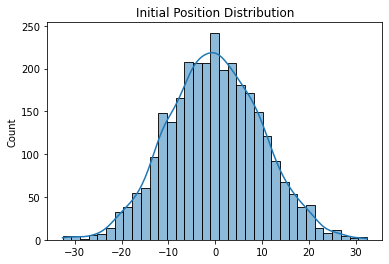

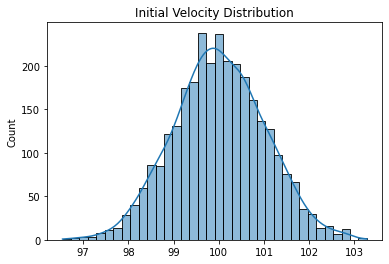

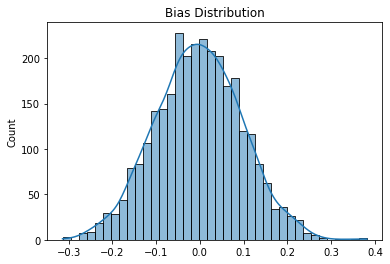

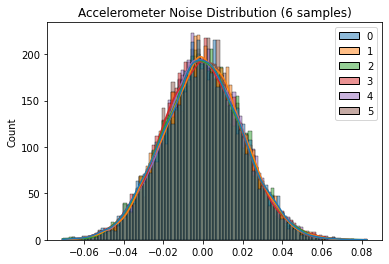

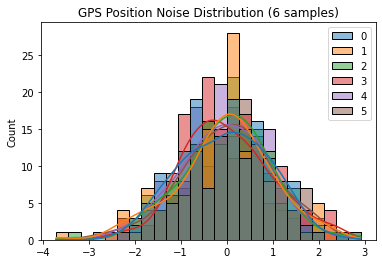

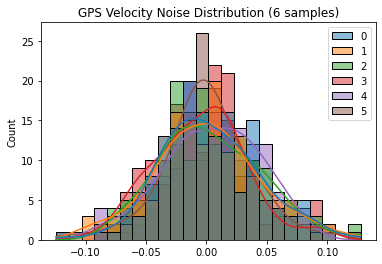

In [5]:
# initialize

x0 = np.random.normal(x_mean, x_var, size=(3,realization))
sns.histplot(x0[0], kde=True); plt.title("Initial Position Distribution"); plt.show()
sns.histplot(x0[1], kde=True); plt.title("Initial Velocity Distribution"); plt.show()
sns.histplot(x0[2], kde=True); plt.title("Bias Distribution"); plt.show()

w = np.random.normal(w_mean, w_var, size=(T*f_j+1,realization))
sns.histplot(w[:,0:6], kde=True); plt.title("Accelerometer Noise Distribution (6 samples)"); plt.show()

h1 = np.random.normal(z_mean[0], z_var[0], size=(T*f_i+1,realization))
h2 = np.random.normal(z_mean[1], z_var[1], size=(T*f_i+1,realization))
h = np.stack([h1, h2], axis=0)

sns.histplot(h[0,:,0:6], kde=True); plt.title("GPS Position Noise Distribution (6 samples)"); plt.show()
sns.histplot(h[1,:,0:6], kde=True); plt.title("GPS Velocity Noise Distribution (6 samples)"); plt.show()

### Calculate Truth Model

\begin{aligned}
&p(t)=p(0)+\left(v(0)+\frac{a}{\omega}\right) t-\frac{a}{\omega^2} \sin (\omega t) \\
&v(t)=v(0)+\frac{a}{\omega}-\frac{a}{\omega} \cos (\omega t) \\
\end{aligned}

In [6]:
# calculate truth model

ap = amplitude/omega
app = amplitude/(omega*omega)
x_j = np.empty((3,6001,realization))
x_i = np.empty((3,151,realization))

for l in np.arange(0,realization):
    p = x0[0][l]+x0[1][l]*t_j+ap*t_j-app*np.sin(omega*t_j)
    v = x0[1][l]+ap*(1-np.cos(omega*t_j))
    b = x0[2][l]*np.ones((np.size(t_j),))

    x_j[:,:,l] = np.vstack((p,v,b))
    x_i[:,:,l] = x_j[:,t_i_index,l]

### Calculate Accelerometer Model

\begin{aligned}
a_c\left(t_j\right) &=a\left(t_j\right)+b+w\left(t_j\right) \\
v_c\left(t_{j+1}\right) &=v_c\left(t_j\right)+a_c\left(t_j\right) \Delta t \\
p_c\left(t_{j+1}\right) &=p_c\left(t_j\right)+v_c\left(t_j\right) \Delta t+a_c\left(t_j\right) \frac{\Delta t^2}{2}
\end{aligned}

In [7]:
# calculate accelerometer model (dynamic programming)

x_c = np.empty((3,6001,realization))
a_c = np.empty((6001,realization))

for l in np.arange(0,realization):
    a_c[:,l] = a + x0[2][l] + w[:,l]

    x_c_dict = {}

    def ACC(t,l):
        if t == 0:              # initial condition
            x_c_dict[0] = x0[:,l].reshape((3,1))
            return x_c_dict[0]
        elif t in x_c_dict:     # recall
            return x_c_dict[t]
        else:                   # recursive step
            x_c_dict[t] = U_c @ ACC(t-1,l) + C * a_c[t-1,l]
            return x_c_dict[t]

    ACC(2000,l)
    ACC(4000,l)
    ACC(6000,l)
    x_c[:,:,l] = np.array(list(x_c_dict.values())).reshape((6001,3)).T

### Calculate Estimated Truth Model

\begin{aligned}
&v_E\left(t_{j+1}\right)=v_E\left(t_j\right)+a\left(t_j\right) \Delta t \\
&p_E\left(t_{j+1}\right)=p_E\left(t_j\right)+v_E\left(t_j\right) \Delta t+a\left(t_j\right) \frac{\Delta t^2}{2}
\end{aligned}

In [8]:
# calculate estimated truth model (dynamic programming)

x_e = np.empty((3,6001,realization))

for l in np.arange(0,realization):
    x_e_dict = {}

    def EST(t,l):
        if t == 0:              # initial condition
            x_e_dict[0] = x0[:,l].reshape((3,1))
            return x_e_dict[0]
        elif t in x_e_dict:     # recall
            return x_e_dict[t]
        else:                   # recursive step
            x_e_dict[t] = U_c @ EST(t-1,l) + C * a[t-1]
            return x_e_dict[t]

    EST(2000,l)
    EST(4000,l)
    EST(6000,l)
    x_e[:,:,l] = np.array(list(x_e_dict.values())).reshape((6001,3)).T

### Plot of States Evolved Over Time (Before Applying Kalman Filter)

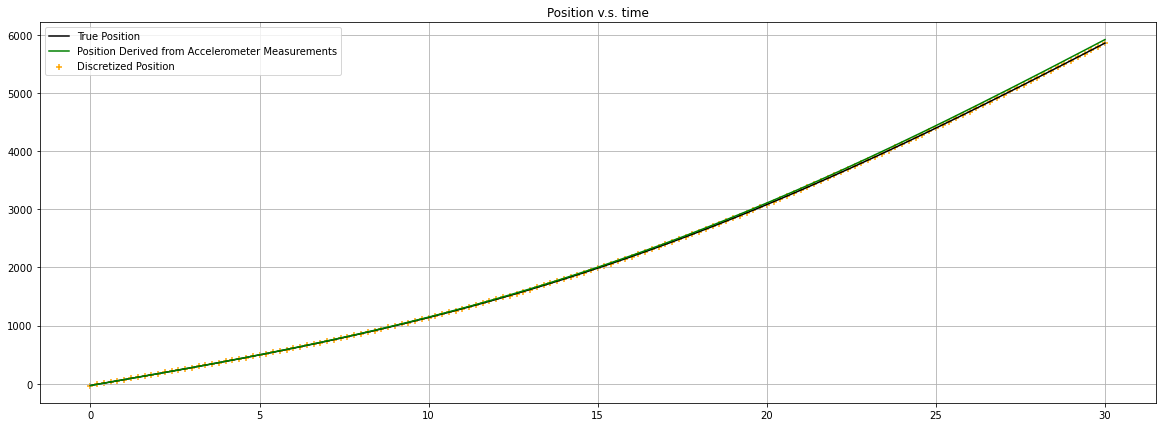

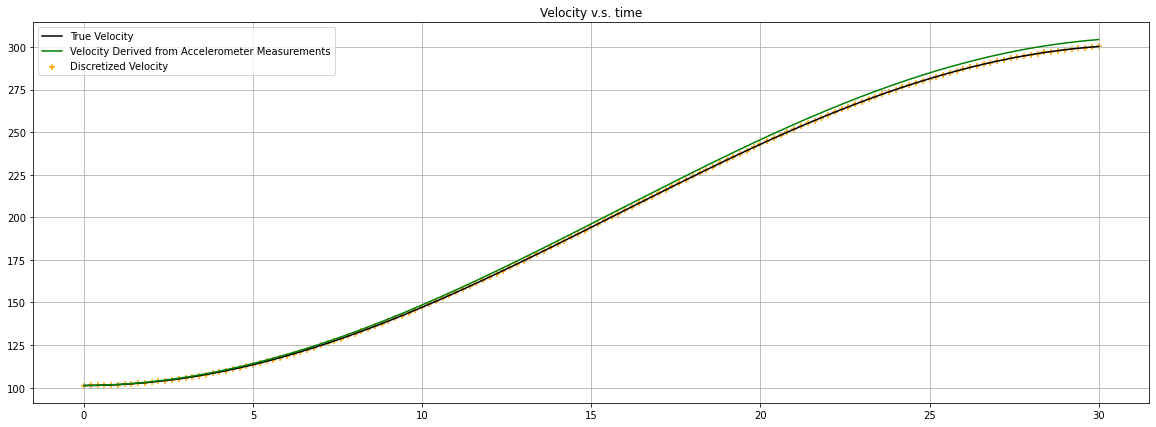

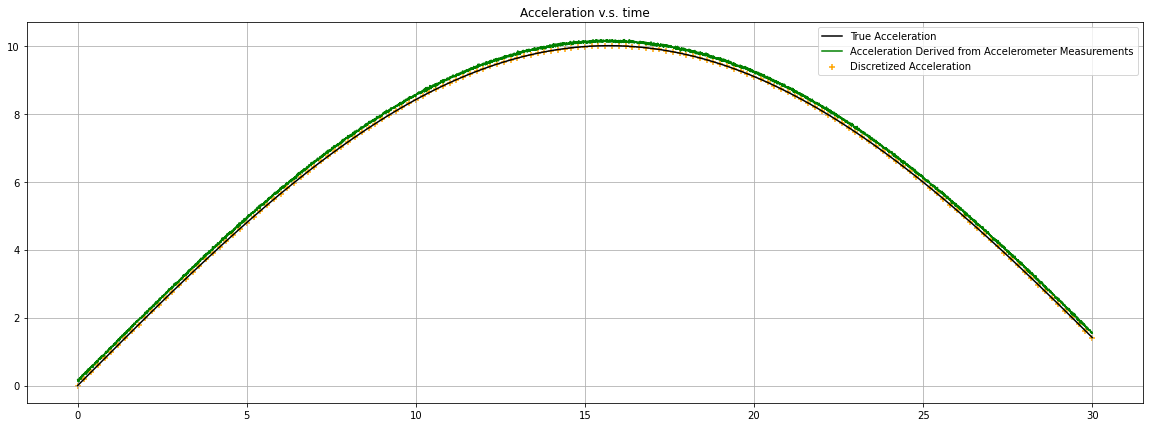

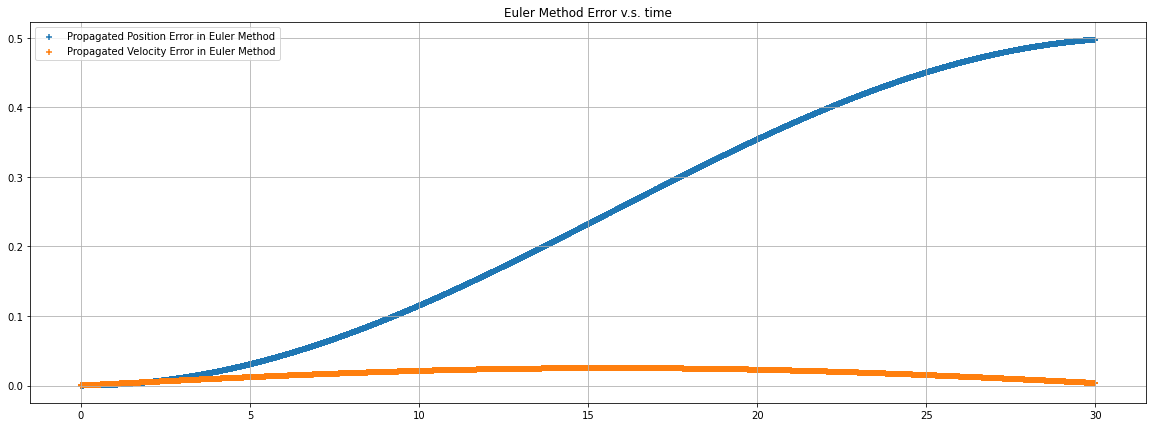

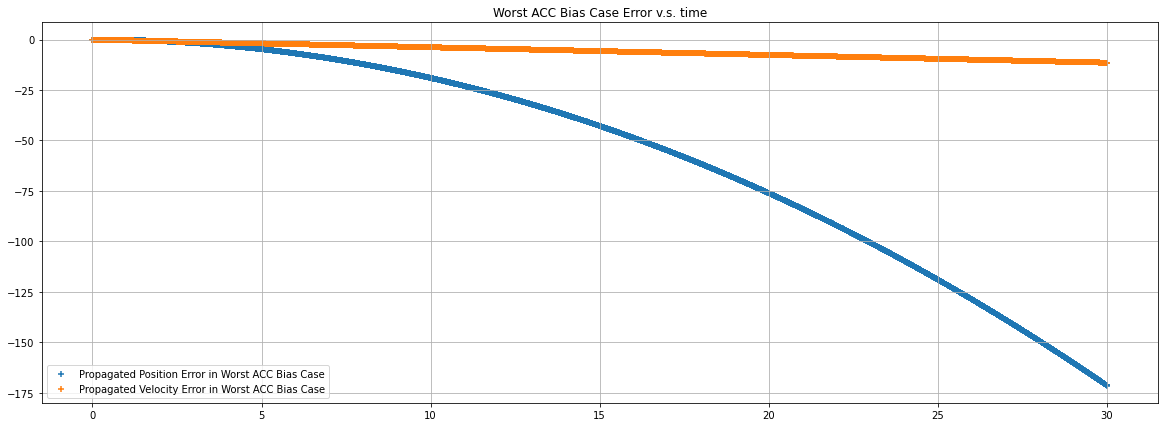

In [156]:
def PLOT1(worstbias,text,truestate,discretized,derived):
    # which realization to plot
    l= np.argmax(np.abs(x0[worstbias][:]))    # find a realization with worst bias  

    # Plot of states evolved over time
    plt.figure(figsize=(20,7))
    plt.plot(t_j,truestate,label = "True " + text,color='k'); 
    plt.scatter(t_i,discretized,label = "Discretized " + text,marker = "+",color='orange'); 
    plt.plot(t_j,derived,label = text + " Derived from Accelerometer Measurements",color='g'); 
    plt.title(text + " v.s. time"); plt.legend(); plt.grid(); plt.show()

PLOT1(2,"Position",x_j[0,:,l],x_e[0,t_i_index,l],x_c[0,:,l])
PLOT1(2,"Velocity",x_j[1,:,l],x_e[1,t_i_index,l],x_c[1,:,l])
PLOT1(2,"Acceleration",a,a[t_i_index],a_c[:,l])

def PLOT2(realization,text,data):
    plt.figure(figsize=(20,7))
    plt.scatter(t_j,x_j[0,:,realization]-data[0,:,realization],label = "Propagated Position Error in " + text, marker = "+");
    plt.scatter(t_j,x_j[1,:,realization]-data[1,:,realization],label = "Propagated Velocity Error in " + text, marker = "+"); 
    plt.title(text + " Error v.s. time"); plt.legend(); plt.grid(); plt.show()

PLOT2(0,"Euler Method",x_e)
PLOT2(np.argmax(np.abs(x0[2][:])),"Worst ACC Bias Case",x_c)

### Implement Kalman Filter  

In [66]:
# Kalman Filter Algorithm on Error Dyanmics

# propagate mean
def propagate_dx(tj,dx0,stop):
    if tj == stop:
        dx_dict[tj] = dx0
        return dx_dict[tj]
    elif tj in dx_dict:
        return dx_dict[tj]
    else:
        dx_dict[tj] = U @ propagate_dx(tj-1,dx0,stop)
        return dx_dict[tj]

# propagate covariance matrix
def propagate_dM(tj,dM0,stop):
    if tj == stop:
        M_dict[tj] = dM0
        return M_dict[tj]
    elif tj in M_dict:
        return M_dict[tj]
    else:
        M_dict[tj] = U @ propagate_dM(tj-1,dM0,stop) @ U.T + C * w[tj-1,l] * C.T
        return M_dict[tj]
    
# Kalman Filter with GPS readings
def KF():
    ti = 0
    P_dict[0] = P0*P0
    r[0] = np.array([[0],[0]])
    error_dict[0] = x0[:,l].reshape((3,1))-x_mean

    for ti in np.arange(1,np.size(t_i)):
        propagate_dx(ti*40,error_dict[ti-1],(ti-1)*40)
        dx = np.array(list(dx_dict.values()))
        dx = dx[:,:,0].T
        propagate_dM(ti*40,P_dict[ti-1],(ti-1)*40)
        dM = np.array(list(M_dict.values()))
        P_dict[ti] = dM[ti*40,:,:] - dM[ti*40,:,:] @ H.T @ scipy.linalg.pinv(H @ dM[ti*40,:,:] @ H.T + V) @ H @ dM[ti*40,:,:]
        r[ti] = (h[:,ti,l].reshape((2,1)) - H @ dx[:,ti*40].reshape((3,1)))
        error_dict[ti] = dx[:,ti*40].reshape((3,1)) + P_dict[ti] @ H.T @ scipy.linalg.pinv(V) @ r[ti]
    return 

# initialize
error = np.empty((3,151,realization)) 
dx = np.empty((3,6001,realization))
dM = np.empty((6001,3,3,realization))
P_variance = np.empty((151,3,3,realization))
res = np.empty((151,2,realization))

for l in np.arange(0,realization):
    error_dict = {}
    M_dict = {}
    P_dict = {}
    r = {}
    dx_dict = {}
    KF()   # run Kalman Filter

    error[:,:,l] = np.array(list(error_dict.values())).reshape((151,3)).T   # error data at ti
    dx[:,:,l] = np.array(list(dx_dict.values())).reshape((6001,3)).T        # error data at tj
    dM[:,:,:,l] = np.array(list(M_dict.values()))                           # error variance
    P_variance[:,:,:,l] = np.array(list(P_dict.values())).reshape((151,3,3))# error variance update
    res[:,:,l] = np.array(list(r.values())).reshape((151,2))                # residuals

### Save Data

In [198]:
# import pickle

# with open('error.pkl', 'wb') as file:
#     pickle.dump(error, file)
# with open('dx.pkl', 'wb') as file:
#     pickle.dump(dx, file)
# with open('dM.pkl', 'wb') as file:
#     pickle.dump(dM, file)
# with open('P_variance.pkl', 'wb') as file:
#     pickle.dump(P_variance, file)
# with open('res.pkl', 'wb') as file:
#     pickle.dump(res, file)
# with open('x0.pkl', 'wb') as file:
#     pickle.dump(x0, file)
# with open('w.pkl', 'wb') as file:
#     pickle.dump(w, file)
# with open('h.pkl', 'wb') as file:
#     pickle.dump(h, file)
# with open('a_c.pkl', 'wb') as file:
#     pickle.dump(a_c, file)
# with open('x_e.pkl', 'wb') as file:
#     pickle.dump(x_e, file)
# with open('x_i.pkl', 'wb') as file:
#     pickle.dump(x_i, file)
# with open('x_j.pkl', 'wb') as file:
#     pickle.dump(x_j, file)
# with open('x_c.pkl', 'wb') as file:
#     pickle.dump(x_c, file)

### Load Data

In [5]:
# import pickle

# with open('error.pkl', 'rb') as file:
#     error = pickle.load(file)
# with open('dx.pkl', 'rb') as file:
#     dx = pickle.load(file)
# with open('dM.pkl', 'rb') as file:
#     dM = pickle.load(file)
# with open('P_variance.pkl', 'rb') as file:
#     P_variance = pickle.load(file)
# with open('res.pkl', 'rb') as file:
#     res = pickle.load(file)
# with open('x0.pkl', 'rb') as file:
#     x0 = pickle.load(file)
# with open('w.pkl', 'rb') as file:
#     w = pickle.load(file)
# with open('h.pkl', 'rb') as file:
#     h = pickle.load(file)
# with open('a_c.pkl', 'rb') as file:
#     a_c = pickle.load(file)
# with open('x_e.pkl', 'rb') as file:
#     x_e = pickle.load(file)
# with open('x_i.pkl', 'rb') as file:
#     x_i = pickle.load(file)
# with open('x_j.pkl', 'rb') as file:
#     x_j = pickle.load(file)
# with open('x_c.pkl', 'rb') as file:
#     x_c = pickle.load(file)

### Generate Plots

#### Variance of States 

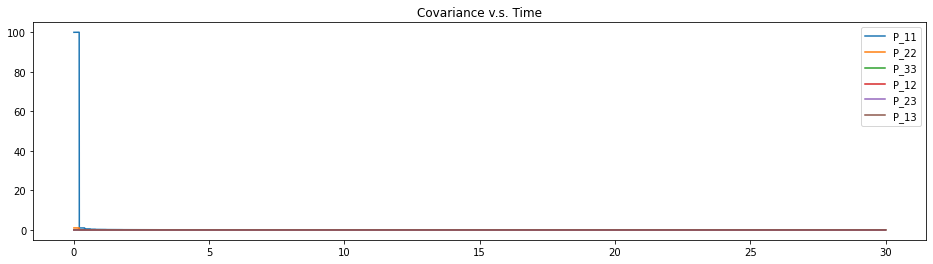

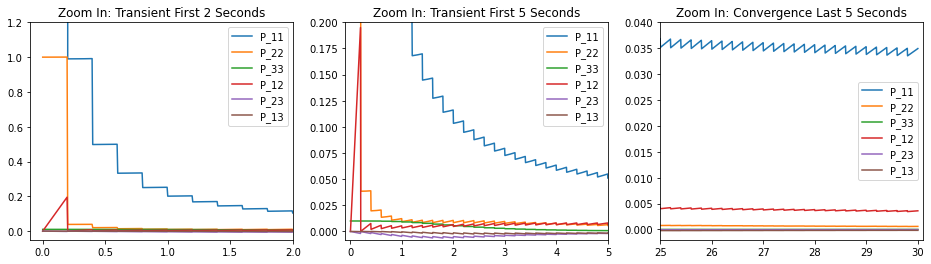

In [188]:
def PLOT3():
    # which realization to plot
    l= np.argmax(np.abs(x0[2][:]))    # find a realization with worst bias      

    def subPLOT3(ax,dt,data):
        ax.plot(dt,data[:,0,0,l],label = "P_11") 
        ax.plot(dt,data[:,1,1,l],label = "P_22")
        ax.plot(dt,data[:,2,2,l],label = "P_33")
        ax.plot(dt,data[:,0,1,l],label = "P_12")
        ax.plot(dt,data[:,1,2,l],label = "P_23")
        ax.plot(dt,data[:,0,2,l],label = "P_13")
    
    plt.figure(figsize=(16,4))
    subPLOT3(plt,t_j,dM)
    plt.title("Covariance v.s. Time"); plt.legend(); #plt.ylim(-0.1,1); 
    plt.savefig('Covariance1.png')
    plt.show();

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'width_ratios': [2, 2, 2]})
    subPLOT3(ax1,t_j,dM)
    ax1.set_title('Zoom In: Transient First 2 Seconds'); ax1.legend(); ax1.set_ylim(-0.05,1.2); ax1.set_xlim(-0.1,2);
    subPLOT3(ax2,t_j,dM)
    ax2.set_title('Zoom In: Transient First 5 Seconds'); ax2.legend(); ax2.set_ylim(-0.008,0.2); ax2.set_xlim(-0.1,5);
    subPLOT3(ax3,t_j,dM)
    ax3.set_title('Zoom In: Convergence Last 5 Seconds'); ax3.legend(); ax3.set_ylim(-0.002,0.04); ax3.set_xlim(25,30.1);
    plt.savefig('Covariance2.png')
    plt.show(); 

PLOT3()


#### Check Invariance of Variance of States 

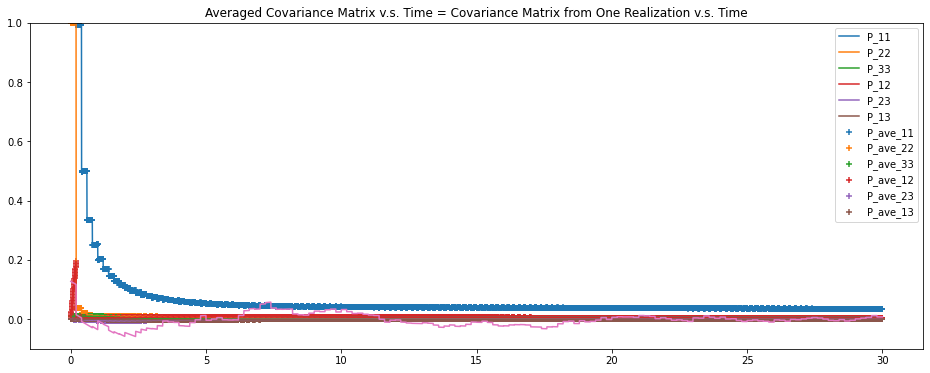

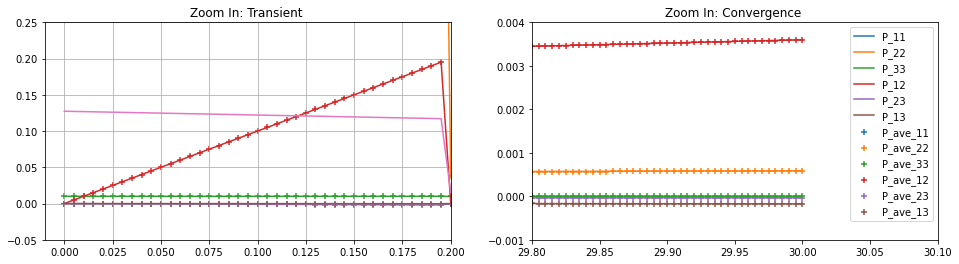

In [170]:
def PLOT3ave():
    # which realization to plot
    l= np.argmax(np.abs(x0[2][:]))    # find a realization with worst bias      

    def subPLOT3(ax,dt,data):
        ax.plot(dt,data[:,0,0,l],label = "P_11") 
        ax.plot(dt,data[:,1,1,l],label = "P_22")
        ax.plot(dt,data[:,2,2,l],label = "P_33")
        ax.plot(dt,data[:,0,1,l],label = "P_12")
        ax.plot(dt,data[:,1,2,l],label = "P_23")
        ax.plot(dt,data[:,0,2,l],label = "P_13")
        
    def subPLOT3ave(ax,dt,data):
        ax.scatter(dt,data[:,0,0,:].sum(axis=1)/(realization-1),label = "P_ave_11", marker = '+') 
        ax.scatter(dt,data[:,1,1,:].sum(axis=1)/(realization-1),label = "P_ave_22", marker = '+')
        ax.scatter(dt,data[:,2,2,:].sum(axis=1)/(realization-1),label = "P_ave_33", marker = '+')
        ax.scatter(dt,data[:,0,1,:].sum(axis=1)/(realization-1),label = "P_ave_12", marker = '+')
        ax.scatter(dt,data[:,1,2,:].sum(axis=1)/(realization-1),label = "P_ave_23", marker = '+')
        ax.scatter(dt,data[:,0,2,:].sum(axis=1)/(realization-1),label = "P_ave_13", marker = '+') 
    
    plt.figure(figsize=(16,6))
    subPLOT3(plt,t_j,dM)
    subPLOT3ave(plt,t_j,dM)
    plt.plot(t_j,dx[1,:,0])
    plt.title("Averaged Covariance Matrix v.s. Time = Covariance Matrix from One Realization v.s. Time"); plt.legend(); plt.ylim(-0.1,1);

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [2, 2]})
    subPLOT3(ax1,t_j,dM)
    subPLOT3ave(ax1,t_j,dM)
    ax1.plot(t_j,dx[1,:,0])
    ax1.set_title('Zoom In: Transient '); ax1.set_ylim(-0.05,0.25); ax1.set_xlim(-0.01,0.2); ax1.grid(); #ax1.legend(); 
    subPLOT3(ax2,t_j,dM)
    subPLOT3ave(ax2,t_j,dM)
    ax2.plot(t_j,dx[1,:,0])
    ax2.set_title('Zoom In: Convergence '); ax2.legend(); ax2.set_ylim(-0.001,0.004); ax2.set_xlim(29.8,30.1);

    plt.show()
PLOT3ave()

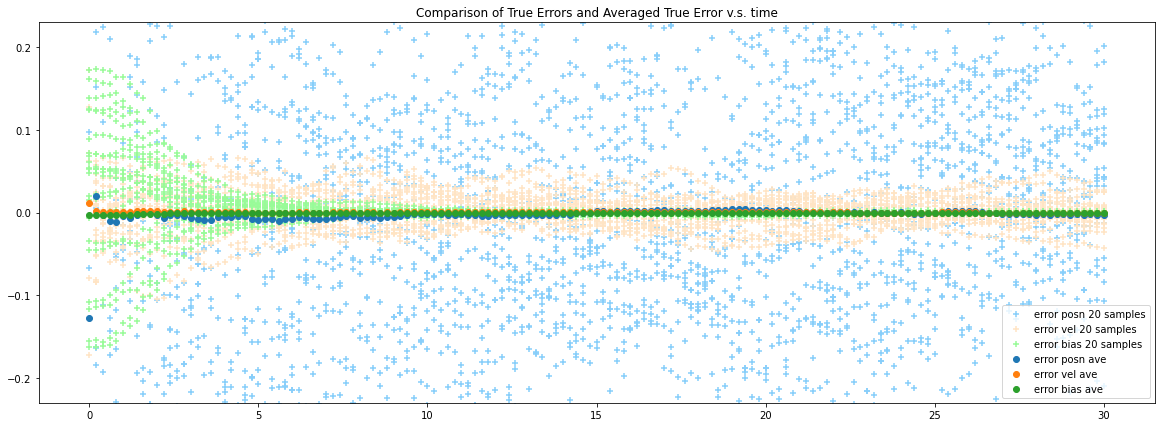

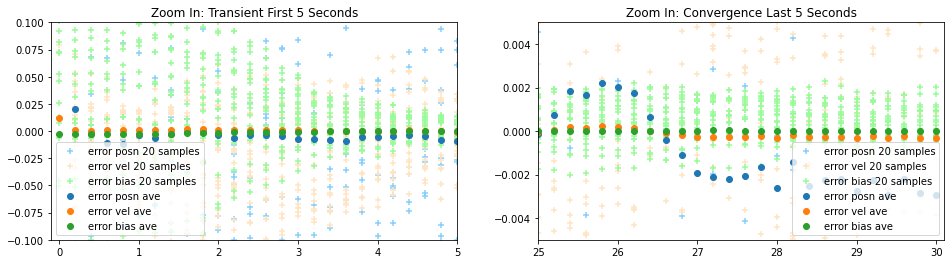

In [184]:
# check posteriori estimation error
true_error = np.empty((3,151,realization))
for l in range(realization):
    for ti in t_i_index:
        if ti == 0:
            true_error[:,ti,l] = dx[:,0,l] #x0[:,l]-x_mean.reshape((3,))  #np.zeros((3,))
        else: 
            true_error[:,ti//40,l] = (U @ dx[:,ti,l].reshape((3,1)) + C * w[ti,l]).reshape((3,))

averaged_true_error = true_error.sum(axis=2)/realization

def subPLOT5(ax):
    ax.scatter(t_i,true_error[0,:,0],label = "error posn 20 samples",color = 'lightskyblue',zorder=0,marker='+')
    for test in np.arange(0,20):
        L = np.random.randint(0, realization)
        ax.scatter(t_i,true_error[0,:,L],color = 'lightskyblue',zorder=0,marker='+'); 
    ax.scatter(t_i,true_error[1,:,0],label = "error vel 20 samples",color = 'bisque',zorder=0,marker='+')
    for test in np.arange(0,20):
        L = np.random.randint(0, realization)
        ax.scatter(t_i,true_error[1,:,L],color = 'bisque',zorder=0,marker='+'); 
    ax.scatter(t_i,true_error[2,:,0],label = "error bias 20 samples",color = 'palegreen',zorder=0,marker='+')
    for test in np.arange(0,20):
        L = np.random.randint(0, realization)
        ax.scatter(t_i,true_error[2,:,L],color = 'palegreen',zorder=0,marker='+'); 
    ax.scatter(t_i,averaged_true_error[0,:],label = "error posn ave")
    ax.scatter(t_i,averaged_true_error[1,:],label = "error vel ave")
    ax.scatter(t_i,averaged_true_error[2,:],label = "error bias ave")
    
plt.figure(figsize=(20,7))
subPLOT5(plt)
plt.title("Comparison of True Errors and Averaged True Error v.s. time"); 
plt.ylim(-0.23,0.23); plt.legend(); 
plt.savefig('aveError1.png')
plt.show();

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [2, 2]})
subPLOT5(ax1)
ax1.set_title('Zoomed in'); ax1.set_title('Zoom In: Transient First 5 Seconds'); 
ax1.legend(); ax1.set_ylim(-0.1,0.1); ax1.set_xlim(-0.1,5);

subPLOT5(ax2)
ax2.set_title('Zoomed out'); ax2.set_title('Zoom In: Convergence Last 5 Seconds'); 
ax2.legend(); ax2.set_ylim(-0.005,0.005); ax2.set_xlim(25,30.1); 
plt.savefig('aveError2.png')
plt.show();


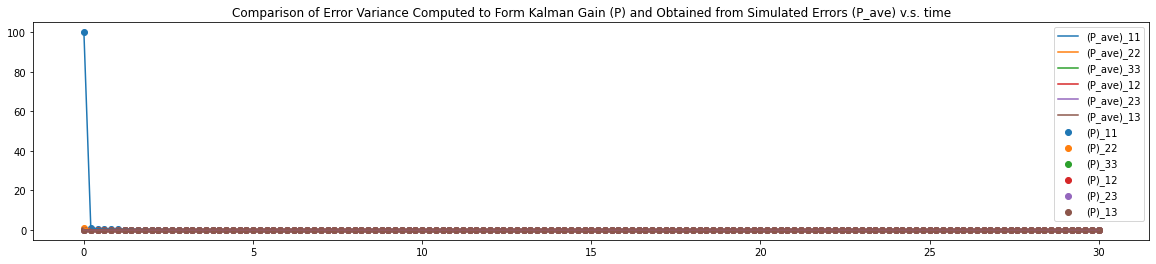

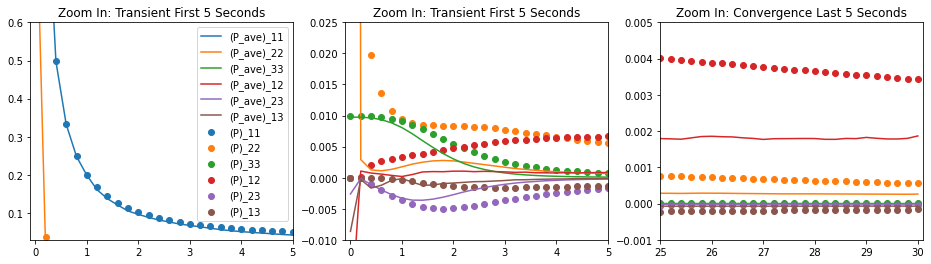

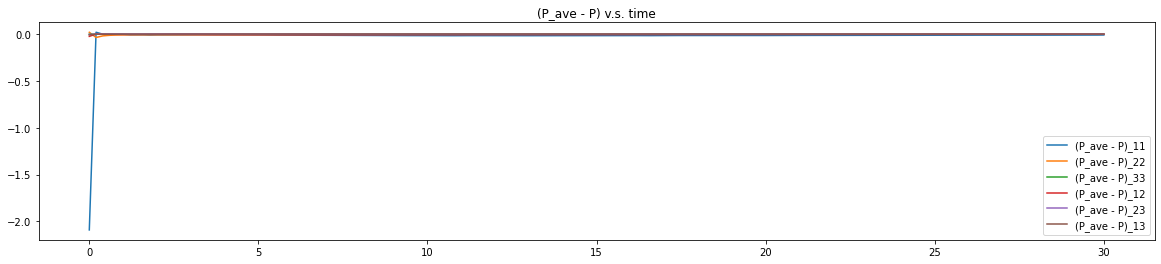

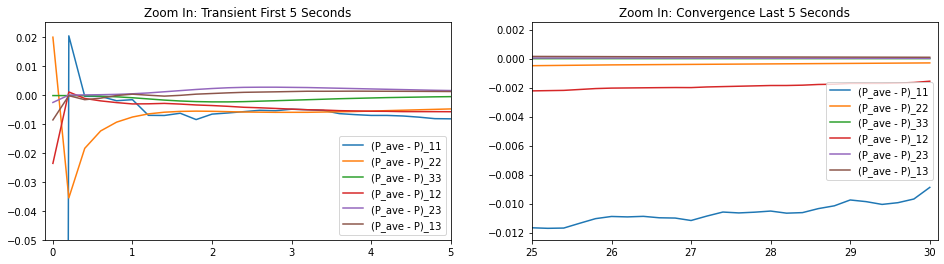

In [194]:
temp_var_error_error = np.empty((151,3,3,realization))
for l in np.arange(0,realization):
    for ti in np.arange(0,151):
        temp = (true_error[:,ti,l]-averaged_true_error[:,ti]).reshape((3,1))
        temp_var_error_error[ti,:,:,l] = temp @ temp.T

P_ave = temp_var_error_error.sum(axis=3)/(realization-1)
averaged_P_variance = P_variance.sum(axis=3)/realization
check_variance = P_ave - averaged_P_variance
dM_ave = dM[t_i_index,:,:,:].sum(axis=3)/realization

def subPLOT4(ax,data,text):
    ax.plot(t_i,data[:,0,0],label = text + "_11"); 
    ax.plot(t_i,data[:,1,1],label = text + "_22"); 
    ax.plot(t_i,data[:,2,2],label = text + "_33"); 
    ax.plot(t_i,data[:,0,1],label = text + "_12"); 
    ax.plot(t_i,data[:,1,2],label = text + "_23"); 
    ax.plot(t_i,data[:,0,2],label = text + "_13"); 
    
def subPLOT4sca(ax,data,text):
    ax.scatter(t_i,data[:,0,0],label = text + "_11"); 
    ax.scatter(t_i,data[:,1,1],label = text + "_22"); 
    ax.scatter(t_i,data[:,2,2],label = text + "_33"); 
    ax.scatter(t_i,data[:,0,1],label = text + "_12"); 
    ax.scatter(t_i,data[:,1,2],label = text + "_23"); 
    ax.scatter(t_i,data[:,0,2],label = text + "_13"); 
    
plt.figure(figsize=(20,4))
subPLOT4(plt,P_ave,"(P_ave)")
subPLOT4sca(plt,averaged_P_variance,"(P)")
plt.title("Comparison of Error Variance Computed to Form Kalman Gain (P) and Obtained from Simulated Errors (P_ave) v.s. time"); 
plt.legend(); 
plt.savefig('cov1.png')
plt.show(); #plt.ylim(-0.07,0.23); 

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'width_ratios': [2, 2, 2]})
subPLOT4(ax1,P_ave,"(P_ave)")
subPLOT4sca(ax1,averaged_P_variance,"(P)")
ax1.set_title('Zoom In: Transient First 5 Seconds'); 
ax1.set_ylim(0.03,0.6); ax1.set_xlim(-0.1,5); ax1.legend(); 

subPLOT4(ax2,P_ave,"(P_ave)")
subPLOT4sca(ax2,averaged_P_variance,"(P)")
ax2.set_title('Zoom In: Transient First 5 Seconds'); 
ax2.set_ylim(-0.01,0.025); ax2.set_xlim(-0.1,5);  #ax2.legend(); 

subPLOT4(ax3,P_ave,"(P_ave)")
subPLOT4sca(ax3,averaged_P_variance,"(P)")
ax3.set_title('Zoom In: Convergence Last 5 Seconds'); 
ax3.set_ylim(-0.001,0.005); ax3.set_xlim(25,30.1); 
plt.savefig('cov2.png')
plt.show(); #ax3.legend(); 



plt.figure(figsize=(20,4))
subPLOT4(plt,check_variance,"(P_ave - P)")
plt.title("(P_ave - P) v.s. time"); 
plt.legend(); 
plt.savefig('PP1.png')
plt.show(); #plt.ylim(-0.07,0.23); 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [2, 2]})
subPLOT4(ax1,check_variance,"(P_ave - P)")
ax1.set_title('Zoom In: Transient First 5 Seconds'); 
ax1.legend(); ax1.set_ylim(-0.05,0.025); ax1.set_xlim(-0.1,5);

subPLOT4(ax2,check_variance,"(P_ave - P)")
ax2.set_title('Zoom In: Convergence Last 5 Seconds'); 
ax2.legend(); ax2.set_ylim(-0.0125,0.0025); ax2.set_xlim(25,30.1); 
plt.savefig('PP2.png')
plt.show();

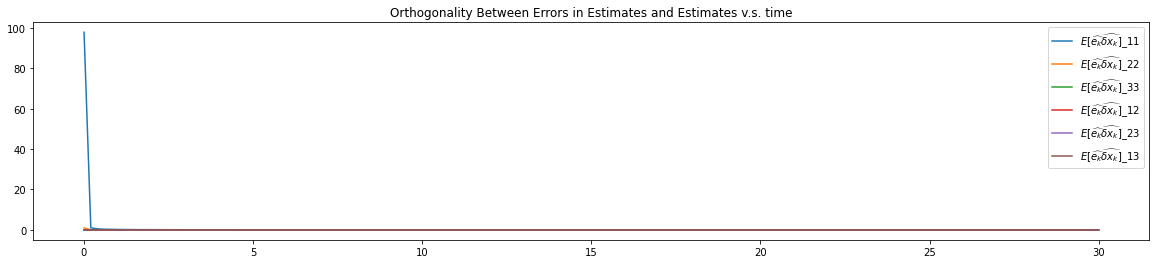

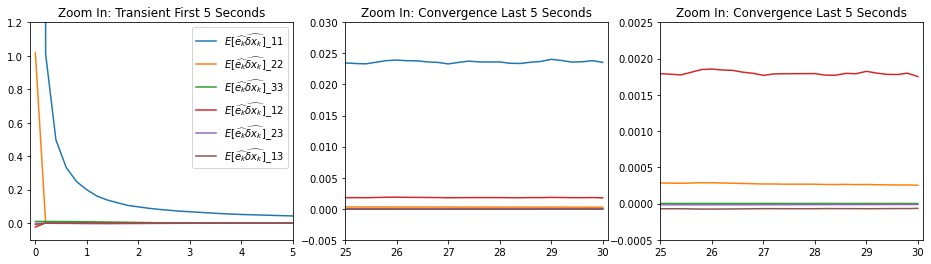

In [193]:
# check orthogonality of the error

temp_var_error_state = np.empty((151,3,3,realization))
for l in np.arange(0,realization):
    for ti in np.arange(0,151):
        tempe = (true_error[:,ti,l]-averaged_true_error[:,ti]).reshape((3,1))
        tempx = (error[:,ti,l]).reshape((3,1)).T
        temp_var_error_state[ti,:,:,l] = tempe @ tempx
var_error_state = temp_var_error_state.sum(axis=3)/(realization)

plt.figure(figsize=(20,4))
subPLOT4(plt,var_error_state,r'$E[\widehat{e_k}\widehat{\delta x_k}]$')
plt.title("Orthogonality Between Errors in Estimates and Estimates v.s. time"); 
plt.legend(); 
plt.savefig('orth1.png')
plt.show() #plt.ylim(-1,7); 

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'width_ratios': [2, 2, 2]})
subPLOT4(ax1,var_error_state,r'$E[\widehat{e_k}\widehat{\delta x_k}]$')
ax1.set_title('Zoomed in'); ax1.set_title('Zoom In: Transient First 5 Seconds'); 
ax1.legend(); ax1.set_ylim(-0.1,1.2); ax1.set_xlim(-0.1,5);

subPLOT4(ax2,var_error_state,r'$E[\widehat{e_k}\widehat{\delta x_k}]$')
ax2.set_title('Zoomed out'); ax2.set_title('Zoom In: Convergence Last 5 Seconds'); 
ax2.set_ylim(-0.005,0.03); ax2.set_xlim(25,30.1); #ax2.legend(); 

subPLOT4(ax3,var_error_state,r'$E[\widehat{e_k}\widehat{\delta x_k}]$')
ax3.set_title('Zoomed out'); ax3.set_title('Zoom In: Convergence Last 5 Seconds'); 
ax3.set_ylim(-0.0005,0.0025); ax3.set_xlim(25,30.1); #ax3.legend(); 
plt.savefig('orth2.png')

plt.show();


In [140]:
# check correlation of the residuals
t__m = 1
res_ave = res.sum(axis=2)/realization

def rr(t__i):
    temp_var_res_res = np.empty((2,2,realization))
    for l in np.arange(0,realization):
        temp_var_res_res[:,:,l] = (res[t__i,:,l]-res_ave[t__i,:]).reshape((2,1)) @ (res[t__m,:,l]-res_ave[t__m,:]).reshape((2,1)).T
    print(temp_var_res_res.sum(axis=2)/(realization))
rr(2) 
rr(50)
rr(100)
rr(150)

[[-0.40632568  0.01687605]
 [ 0.00911497  0.03889521]]
[[-0.04230762 -0.00630973]
 [-0.00755137 -0.000122  ]]
[[-1.82995360e-01  1.37765640e-04]
 [ 5.54068025e-03  3.71605702e-04]]
[[-0.08992215  0.0083329 ]
 [ 0.00048751  0.00093837]]


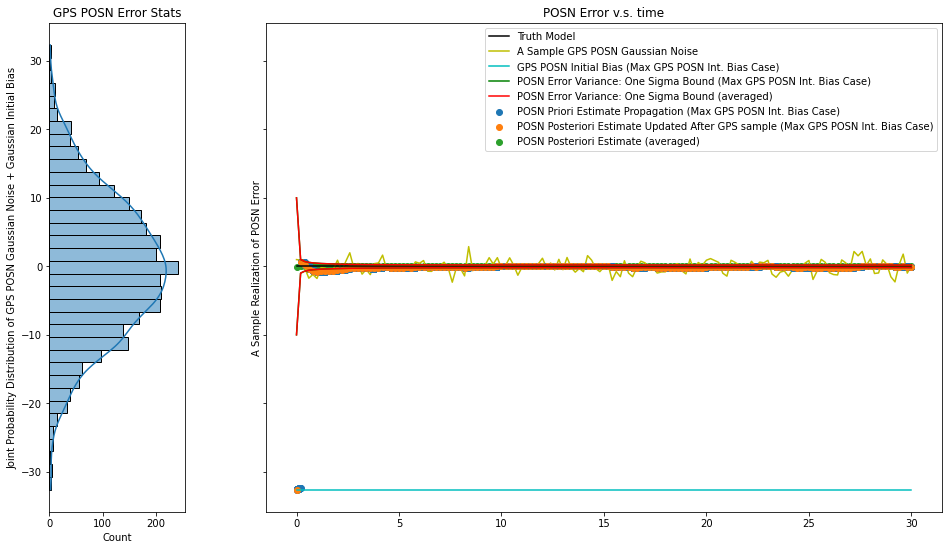

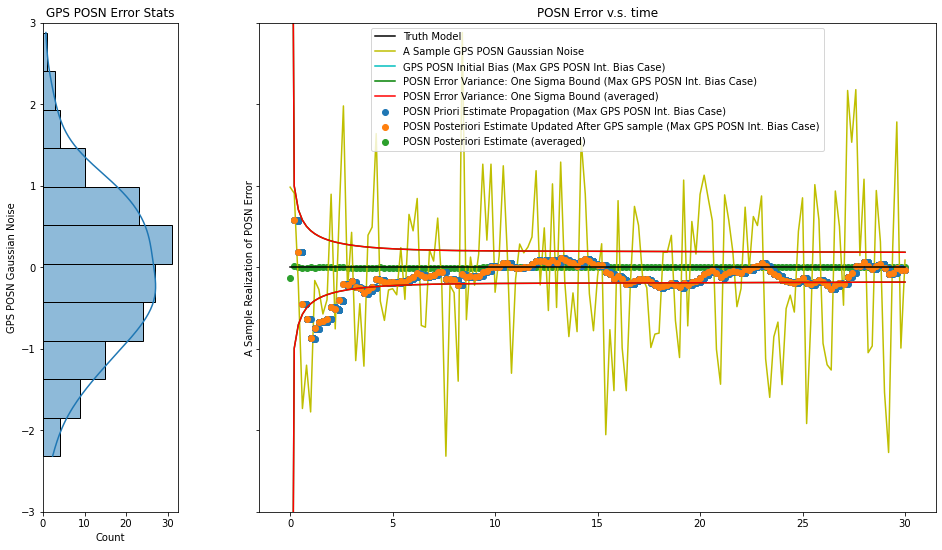

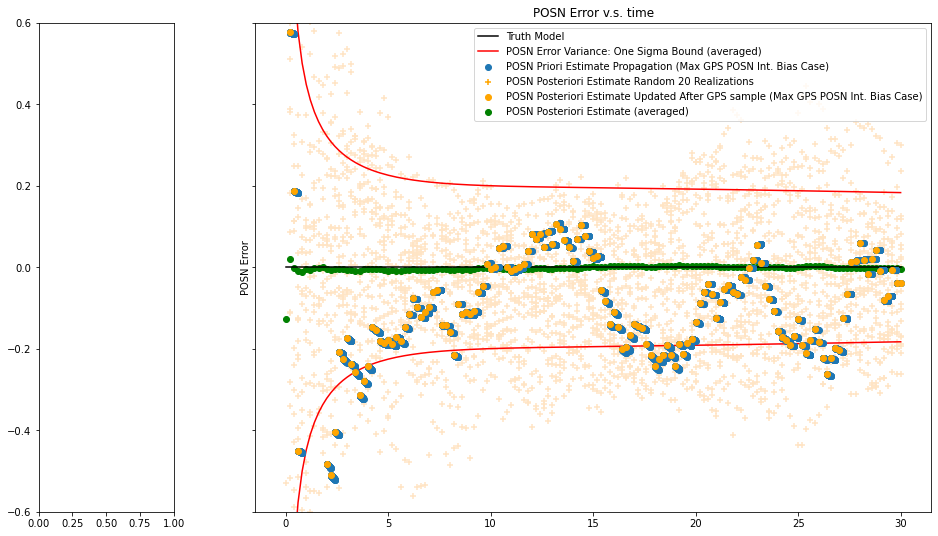

In [195]:
mean_error = error.sum(axis=2)/realization


# which realization to plot
l= np.argmax(np.abs(x0[0][:]))    # find a realization with worst bias      

# plot position
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

#ax1.plot
ax1.set_title('GPS POSN Error Stats')
ax1.set_ylabel('Joint Probability Distribution of GPS POSN Gaussian Noise + Gaussian Initial Bias')
data = [x0[0,l]+h[0,:,l].sum(axis=0)/6001 for l in np.arange(0,realization)]
sns.histplot(ax=ax1, y=data, kde=True)

#ax2.plot
ax2.set_title('POSN Error v.s. time')
ax2.set_ylabel('A Sample Realization of POSN Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=1); 
ax2.plot(t_i,h[0,:,l],label = "A Sample GPS POSN Gaussian Noise",color = "y",zorder=0); 
ax2.plot(t_i,np.ones((151))*(x0[0,l]),label = "GPS POSN Initial Bias (Max GPS POSN Int. Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[0,:,l],label = "POSN Priori Estimate Propagation (Max GPS POSN Int. Bias Case)"); 
ax2.scatter(t_i,error[0,:,l],label = "POSN Posteriori Estimate Updated After GPS sample (Max GPS POSN Int. Bias Case)"); 
ax2.plot(t_i,np.sqrt(P_variance[:,0,0,l]),label = "POSN Error Variance: One Sigma Bound (Max GPS POSN Int. Bias Case)",color = "g"); 
ax2.plot(t_i,-np.sqrt(P_variance[:,0,0,l]),color = "g"); 
ax2.scatter(t_i,mean_error[0,:],label = "POSN Posteriori Estimate (averaged)",zorder=0); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,0,0]),label = "POSN Error Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,0,0]),color = "r"); 
plt.legend(); 
plt.savefig('POSN1.png')


# plot position
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

ax1.set_title('GPS POSN Error Stats')
ax1.set_ylabel('GPS POSN Gaussian Noise')
sns.histplot(ax=ax1, y=h[0,:,l], kde=True)

#ax2.plot
ax2.set_title('POSN Error v.s. time')
ax2.set_ylabel('A Sample Realization of POSN Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=1); 
ax2.plot(t_i,h[0,:,l],label = "A Sample GPS POSN Gaussian Noise",color = "y",zorder=0); 
ax2.plot(t_i,np.ones((151))*(x0[0,l]),label = "GPS POSN Initial Bias (Max GPS POSN Int. Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[0,:,l],label = "POSN Priori Estimate Propagation (Max GPS POSN Int. Bias Case)"); 
ax2.scatter(t_i,error[0,:,l],label = "POSN Posteriori Estimate Updated After GPS sample (Max GPS POSN Int. Bias Case)"); 
ax2.plot(t_i,np.sqrt(P_variance[:,0,0,l]),label = "POSN Error Variance: One Sigma Bound (Max GPS POSN Int. Bias Case)",color = "g"); 
ax2.plot(t_i,-np.sqrt(P_variance[:,0,0,l]),color = "g"); 
ax2.scatter(t_i,mean_error[0,:],label = "POSN Posteriori Estimate (averaged)",zorder=0); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,0,0]),label = "POSN Error Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,0,0]),color = "r"); 
ax2.set_ylim(-3,3); plt.legend(); 
plt.savefig('POSN2.png')


# plot position
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

#ax1.set_title('GPS POSN Error Stats')
#ax1.set_ylabel('GPS POSN Gaussian Noise')
#sns.histplot(ax=ax1, y=h[0,:,l], kde=True)

#ax2.plot
ax2.set_title('POSN Error v.s. time')
ax2.set_ylabel('POSN Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=1); 
#ax2.plot(t_i,h[0,:,l],label = "A Sample GPS POSN Gaussian Noise",color = "y",zorder=0); 
#ax2.plot(t_i,np.ones((151))*(x0[0,l]),label = "GPS POSN Initial Bias (Max GPS POSN Int. Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[0,:,l],label = "POSN Priori Estimate Propagation (Max GPS POSN Int. Bias Case)",zorder=10); 
ax2.scatter(t_i,error[0,:,l],label = "POSN Posteriori Estimate Random 20 Realizations",color = 'orange',zorder=0,marker='+');
for test in np.arange(0,20):
    L = np.random.randint(0, realization)
    ax2.scatter(t_i,error[0,:,L],color = 'bisque',zorder=0,marker='+'); 
ax2.scatter(t_i,error[0,:,l],label = "POSN Posteriori Estimate Updated After GPS sample (Max GPS POSN Int. Bias Case)",color = 'orange',zorder=100);
#ax2.plot(t_i,np.sqrt(P_variance[:,0,0,l]),label = "POSN Error Variance: One Sigma Bound (Max GPS POSN Int. Bias Case)",color = "g"); 
#ax2.plot(t_i,-np.sqrt(P_variance[:,0,0,l]),color = "g"); 
ax2.scatter(t_i,mean_error[0,:],label = "POSN Posteriori Estimate (averaged)",zorder=0,color = 'g'); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,0,0]),label = "POSN Error Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,0,0]),color = "r"); 
ax2.set_ylim(-0.6,0.6); plt.legend(); 
plt.savefig('POSN3.png')


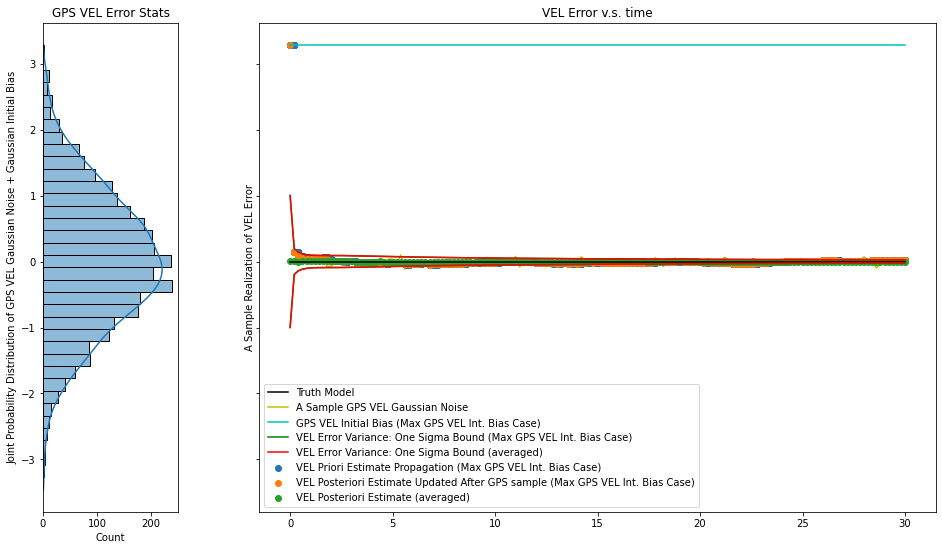

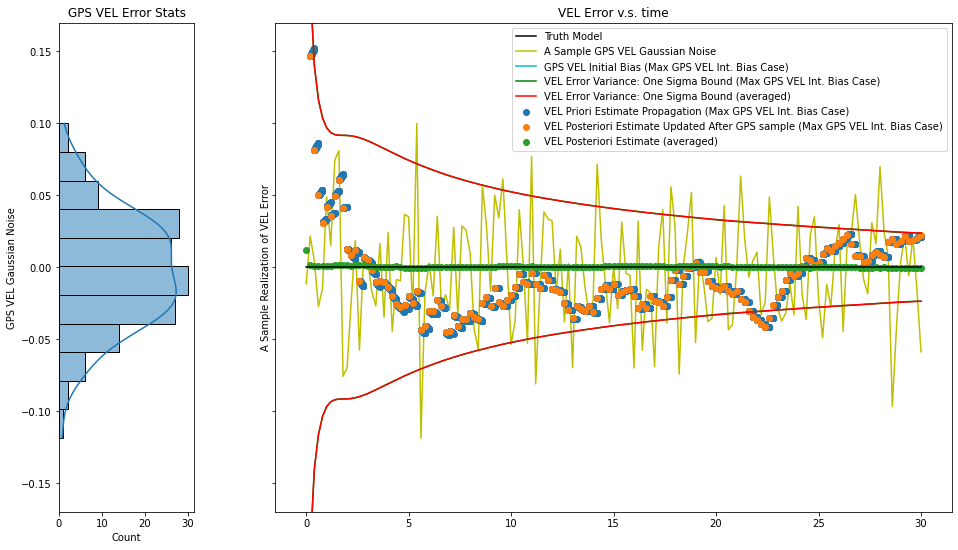

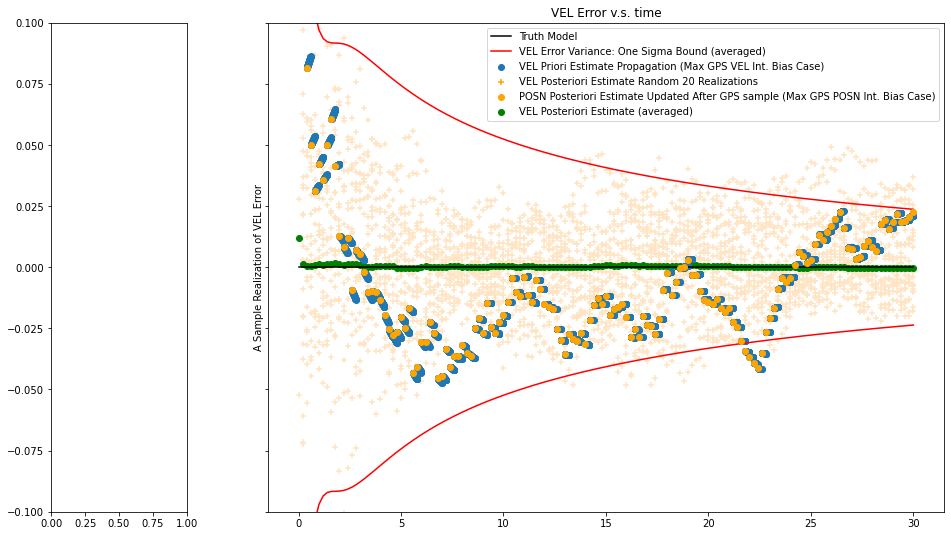

In [196]:
# which realization to plot
l= np.argmax(np.abs(x0[1][:]))    # find a realization with worst bias  

# plot velocity
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

#ax1.plot
ax1.set_title('GPS VEL Error Stats')
ax1.set_ylabel('Joint Probability Distribution of GPS VEL Gaussian Noise + Gaussian Initial Bias')
x0_var = x0[1,:]-x_mean[1]
data = [x0_var[l]+h[1,:,l].sum(axis=0)/6001 for l in np.arange(0,realization)]
sns.histplot(ax=ax1, y=data, kde=True)

#ax2.plot
ax2.set_title('VEL Error v.s. time')
ax2.set_ylabel('A Sample Realization of VEL Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=1); 
ax2.plot(t_i,h[1,:,l],label = "A Sample GPS VEL Gaussian Noise",color = "y",zorder=0); 
ax2.plot(t_i,np.ones((151))*(x0[1,l]-x_mean[1]),label = "GPS VEL Initial Bias (Max GPS VEL Int. Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[1,:,l],label = "VEL Priori Estimate Propagation (Max GPS VEL Int. Bias Case)"); 
ax2.scatter(t_i,error[1,:,l],label = "VEL Posteriori Estimate Updated After GPS sample (Max GPS VEL Int. Bias Case)"); 
ax2.plot(t_i,np.sqrt(P_variance[:,1,1,l]),label = "VEL Error Variance: One Sigma Bound (Max GPS VEL Int. Bias Case)",color = "g"); 
ax2.plot(t_i,-np.sqrt(P_variance[:,1,1,l]),color = "g"); 
ax2.scatter(t_i,mean_error[1,:],label = "VEL Posteriori Estimate (averaged)"); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,1,1]),label = "VEL Error Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,1,1]),color = "r"); 
plt.legend(); 
plt.savefig('VEL1.png')


# plot velocity
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

ax1.set_title('GPS VEL Error Stats')
ax1.set_ylabel('GPS VEL Gaussian Noise')
sns.histplot(ax=ax1, y=h[1,:,l], kde=True)

#ax2.plot
ax2.set_title('VEL Error v.s. time')
ax2.set_ylabel('A Sample Realization of VEL Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=1); 
ax2.plot(t_i,h[1,:,l],label = "A Sample GPS VEL Gaussian Noise",color = "y",zorder=0); 
ax2.plot(t_i,np.ones((151))*(x0[1,l]-x_mean[1]),label = "GPS VEL Initial Bias (Max GPS VEL Int. Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[1,:,l],label = "VEL Priori Estimate Propagation (Max GPS VEL Int. Bias Case)"); 
ax2.scatter(t_i,error[1,:,l],label = "VEL Posteriori Estimate Updated After GPS sample (Max GPS VEL Int. Bias Case)"); 
ax2.plot(t_i,np.sqrt(P_variance[:,1,1,l]),label = "VEL Error Variance: One Sigma Bound (Max GPS VEL Int. Bias Case)",color = "g"); 
ax2.plot(t_i,-np.sqrt(P_variance[:,1,1,l]),color = "g"); 
ax2.scatter(t_i,mean_error[1,:],label = "VEL Posteriori Estimate (averaged)"); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,1,1]),label = "VEL Error Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,1,1]),color = "r"); 
ax2.set_ylim(-0.17,0.17); plt.legend(); 
plt.savefig('VEL2.png')


# plot velocity
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

#ax1.set_title('GPS VEL Error Stats')
#ax1.set_ylabel('GPS VEL Gaussian Noise')
#sns.histplot(ax=ax1, y=h[1,:,l], kde=True)

#ax2.plot
ax2.set_title('VEL Error v.s. time')
ax2.set_ylabel('A Sample Realization of VEL Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=1); 
#ax2.plot(t_i,h[1,:,l],label = "A Sample GPS VEL Gaussian Noise",color = "y",zorder=0); 
#ax2.plot(t_i,np.ones((151))*(x0[1,l]-x_mean[1]),label = "GPS VEL Initial Bias (Max GPS VEL Int. Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[1,:,l],label = "VEL Priori Estimate Propagation (Max GPS VEL Int. Bias Case)"); 
ax2.scatter(t_i,error[1,:,l],label = "VEL Posteriori Estimate Random 20 Realizations",color = 'orange',zorder=0,marker='+'); 
for test in np.arange(0,20):
    L = np.random.randint(0, realization)
    ax2.scatter(t_i,error[1,:,L],color = 'bisque',zorder=0,marker='+'); 
ax2.scatter(t_i,error[1,:,l],label = "POSN Posteriori Estimate Updated After GPS sample (Max GPS POSN Int. Bias Case)",color = 'orange',zorder=100);
#ax2.plot(t_i,np.sqrt(P_variance[:,1,1,l]),label = "VEL Error Variance: One Sigma Bound (Max GPS VEL Int. Bias Case)",color = "g"); 
#ax2.plot(t_i,-np.sqrt(P_variance[:,1,1,l]),color = "g"); 
ax2.scatter(t_i,mean_error[1,:],label = "VEL Posteriori Estimate (averaged)",zorder=0,color = 'g'); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,1,1]),label = "VEL Error Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,1,1]),color = "r"); 
ax2.set_ylim(-0.1,0.1); plt.legend(); 
plt.savefig('VEL3.png')


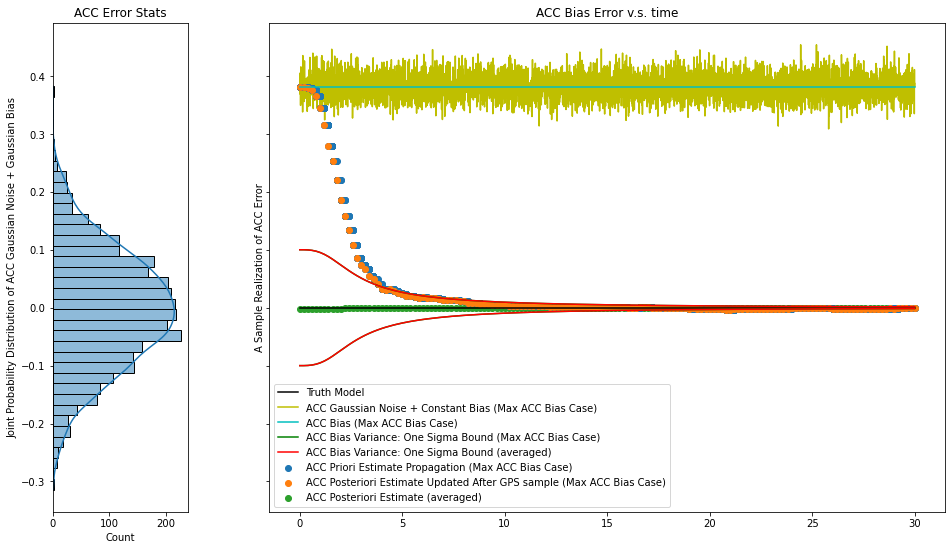

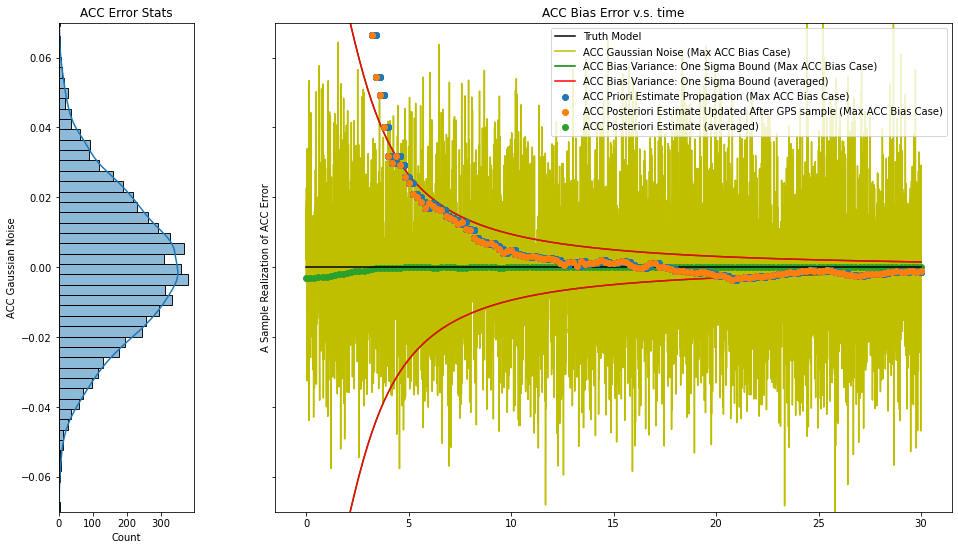

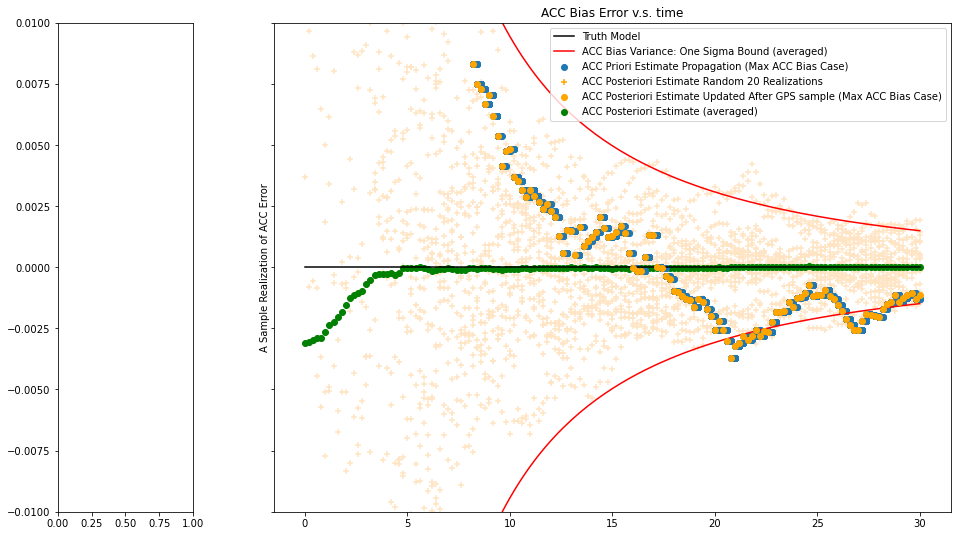

In [197]:
# which realization to plot
l= np.argmax(np.abs(x0[2][:]))    # find a realization with worst bias

# plot acceleration
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

#ax1.plot
ax1.set_title('ACC Error Stats')
ax1.set_ylabel('Joint Probability Distribution of ACC Gaussian Noise + Gaussian Bias')
data = [x0[2,l]+w[:,l].sum(axis=0)/6001 for l in np.arange(0,realization)]
sns.histplot(ax=ax1, y=data, kde=True)

#ax2.plot
ax2.set_title('ACC Bias Error v.s. time')
ax2.set_ylabel('A Sample Realization of ACC Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=1); 
ax2.plot(t_j,a_c[:,l]-a,label = "ACC Gaussian Noise + Constant Bias (Max ACC Bias Case)",color = "y",zorder=0); 
ax2.plot(t_i,np.ones((151))*x0[2,l],label = "ACC Bias (Max ACC Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[2,:,l],label = "ACC Priori Estimate Propagation (Max ACC Bias Case)"); 
ax2.scatter(t_i,error[2,:,l],label = "ACC Posteriori Estimate Updated After GPS sample (Max ACC Bias Case)"); 
ax2.plot(t_i,np.sqrt(P_variance[:,2,2,l]),label = "ACC Bias Variance: One Sigma Bound (Max ACC Bias Case)",color = "g"); 
ax2.plot(t_i,-np.sqrt(P_variance[:,2,2,l]),color = "g"); 
ax2.scatter(t_i,mean_error[2,:],label = "ACC Posteriori Estimate (averaged)",zorder=0); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,2,2]),label = "ACC Bias Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,2,2]),color = "r"); 
plt.legend(); 
plt.savefig('ACC1.png')


# plot acceleration
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

#ax1.plot
ax1.set_title('ACC Error Stats')
ax1.set_ylabel('ACC Gaussian Noise')
sns.histplot(ax=ax1, y=w[:,l], kde=True)

#ax2.plot
ax2.set_title('ACC Bias Error v.s. time')
ax2.set_ylabel('A Sample Realization of ACC Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=20); 
ax2.plot(t_j,a_c[:,l]-a-x0[2,l],label = "ACC Gaussian Noise (Max ACC Bias Case)",color = "y",zorder=0); 
#ax2.plot(t_i,np.ones((151))*x0[2,l],label = "ACC Bias (Max ACC Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[2,:,l],label = "ACC Priori Estimate Propagation (Max ACC Bias Case)",zorder=30); 
ax2.scatter(t_i,error[2,:,l],label = "ACC Posteriori Estimate Updated After GPS sample (Max ACC Bias Case)",zorder=40); 
ax2.plot(t_i,np.sqrt(P_variance[:,2,2,l]),label = "ACC Bias Variance: One Sigma Bound (Max ACC Bias Case)",color = "g"); 
ax2.plot(t_i,-np.sqrt(P_variance[:,2,2,l]),color = "g"); 
ax2.scatter(t_i,mean_error[2,:],label = "ACC Posteriori Estimate (averaged)",zorder=10); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,2,2]),label = "ACC Bias Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,2,2]),color = "r"); 
ax2.set_ylim(-0.07,0.07); plt.legend(); 

plt.savefig('ACC2.png')

# plot acceleration
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(16,9), gridspec_kw={'width_ratios': [1, 5]})

#ax1.plot
#ax1.set_title('ACC Error Stats')
#ax1.set_ylabel('ACC Gaussian Noise')
#sns.histplot(ax=ax1, y=w[:,l]+x0[2][l], kde=True)

#ax2.plot
ax2.set_title('ACC Bias Error v.s. time')
ax2.set_ylabel('A Sample Realization of ACC Error')
ax2.plot(t_i,np.zeros((151)),label = "Truth Model",color = "k",zorder=1); 
#ax2.plot(t_j,a_c[:,l]-a,label = "ACC Gaussian Noise + Constant Bias (Max ACC Bias Case)",color = "y",zorder=0); 
#ax2.plot(t_i,np.ones((151))*x0[2,l],label = "ACC Bias (Max ACC Bias Case)",color = "c",zorder=20);
ax2.scatter(t_j,dx[2,:,l],label = "ACC Priori Estimate Propagation (Max ACC Bias Case)"); 
ax2.scatter(t_i,error[2,:,l],label = "ACC Posteriori Estimate Random 20 Realizations",color = 'orange',zorder=0,marker='+'); 
for test in np.arange(0,20):
    L = np.random.randint(0, realization)
    ax2.scatter(t_i,error[2,:,L],color = 'bisque',zorder=0,marker='+'); 
ax2.scatter(t_i,error[2,:,l],label = "ACC Posteriori Estimate Updated After GPS sample (Max ACC Bias Case)",color = 'orange',zorder=100);
#ax2.plot(t_i,np.sqrt(P_variance[:,2,2,l]),label = "ACC Bias Variance: One Sigma Bound (Max ACC Bias Case)",color = "g"); 
#ax2.plot(t_i,-np.sqrt(P_variance[:,2,2,l]),color = "g"); 
ax2.scatter(t_i,mean_error[2,:],label = "ACC Posteriori Estimate (averaged)",zorder=0,color = 'g'); 
ax2.plot(t_i,np.sqrt(averaged_P_variance[:,2,2]),label = "ACC Bias Variance: One Sigma Bound (averaged)",color = "r"); 
ax2.plot(t_i,-np.sqrt(averaged_P_variance[:,2,2]),color = "r"); 
ax2.set_ylim(-0.01,0.01); plt.legend(); 
plt.savefig('ACC3.png')
